# Machine Learning Engineer Nanodegree

## Capstone Project

### Using Computer Vision for Facial Expression Classification

This project seeks to investigate the use of computer vision techniques to build a classifier that can classify different faces, based on facial expressions.

A deep learning approach will be taken to this problem, investigating the use of convolutional neural networks (CNNs). 

A simple benchmark CNN will first be investigated, followed by a more complex and deep network.

In addition, the use of pre-existing architectures for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/) will be explored to aid performance in the facial expression classification problem. 






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint  

from keras import losses
from keras import backend as K
from keras import applications
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.


### Reading the Data

The dataset can be obtained from [here](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge). For the purpose of this notebook, and determining the best classification model, only the first 15,000 entries will be used. Later, the entire dataset will be used for training, testing and validation on the optimal model, to gain an idea for the true performance of the model.

Below, Pandas is used to read the input data into a Data Frame

In [2]:
use_section_data = False
smaller_section_data = False

if use_section_data:
    data = pd.read_csv("section_fer2013.csv")    
    if smaller_section_data:
        data = pd.read_csv("smaller_section_fer2013.csv")
else:
    data = pd.read_csv("fer2013cp.csv")

labels = data['emotion']

features = data.drop(['emotion','Usage'], axis=1, inplace=False)


### Pre-Processing the Data

The raw data is in .csv format, with every pixel value listed in a single cell, for each image, separated by spaces.

Below, each pixel value is separated, to be an individual value in a Python list, within a Data Frame.

In addition, the data will be converted to a tensor format.

In [3]:
temp_list = []

for i in features['pixels']:
    temp_list.append(i.split())
    
features.drop('pixels',axis=1,inplace=True)

features['pixels'] = pd.Series(temp_list)

Of all of the data that has been imported, 20% will be used for training, 10% for validation, and 70% for training.

In [4]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.2, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, random_state=0)

In [5]:
def df_to_tensor(X_in, im_dim, reshape=True, triple_channels=False, horizontal_flip_double=False):
    
    # convert from the dataframe which contains Python lists with all pixel values, into a tensor, suitable for
    # input into a convolutional neural network
    
    list_of_2d_arrays = []
    
    
    
    for image in X_in['pixels']:
        pixel_array = []
        
        for pixel in image:
            if not triple_channels:
                pixel_array.append(int(pixel))
            else:
                pixel_array.append([int(pixel),int(pixel),int(pixel)])
        
        pixel_array = [pixel_array[x:x+im_dim] for x in range(0,len(pixel_array),im_dim)]
        
        
        
        list_of_2d_arrays.append(pixel_array)
        
    if horizontal_flip_double == True:
        
        reversed_array = []
        
        for pixel_row in pixel_array:
            reversed_array.append(pixel_row[::-1])
            
        list_of_2d_arrays.append(reversed_array)
            
            
        
        
    np_arr =  np.array(list_of_2d_arrays)
    
    if reshape:
        return np_arr.reshape(np_arr.shape[0], 48, 48, 1)
    else:
        return np_arr

### Sample Visualization

A few of the images from the dataset will be plotted below.

In [6]:
# take a few sample images to provide a visualization

samples = df_to_tensor(features,48)

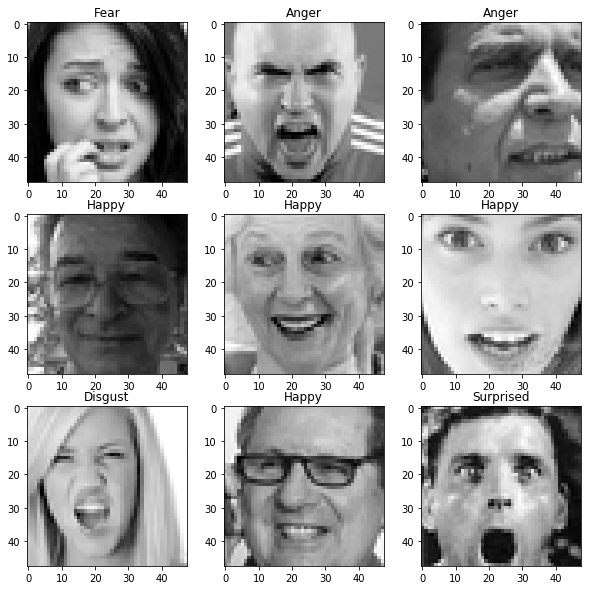

In [7]:
seed_number = 21

two_d_array = samples[seed_number].reshape(48,48)

fig = plt.figure(figsize=(10, 10))

num_rows = 3

num_columns = 3

hardcoded_labels = ["Fear", "Anger", "Anger", "Happy", "Happy",
                   "Happy", "Disgust", "Happy", "Surprised"]

for i in range(num_rows*num_columns):
    ax = fig.add_subplot(num_rows,num_columns,i + 1)
    ax.imshow(samples[seed_number + i].reshape(48,48), cmap='gray')
    ax.title.set_text(hardcoded_labels[i])



### Frequency of Expressions

The distribution of how many times each expression appears in the dataset is important to inform what metrics are suitable for assessing the classifier. Below a bar graph showing the relative frequencies of each expression is shown.

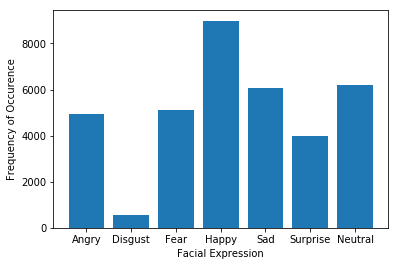

In [8]:
# seeing the distribution of each emotion in the dataset

frequency_list = np.zeros(7)

for label in labels:
    frequency_list[int(label)] += 1
    
emotion_indices = range(1,8)

x_axis_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise',
         'Neutral']


bar = plt.bar(emotion_indices, frequency_list, align='center')

plt.xticks(emotion_indices, x_axis_labels )

plt.xlabel("Facial Expression")

plt.ylabel("Frequency of Occurence")



plt.show()

In [9]:
train_tensors = df_to_tensor(X_train,48).astype('float32')/255
valid_tensors = df_to_tensor(X_val,48).astype('float32')/255
test_tensors = df_to_tensor(X_test,48).astype('float32')/255

train_targets = np.array(pd.get_dummies(y_train))
valid_targets = np.array(pd.get_dummies(y_val))
test_targets = np.array(pd.get_dummies(y_test))


In [10]:
img_width = 48
img_height = 48

### Evaluation Metrics

Due to the uneven distribution of facial expressions in the dataset, illustrated above, accuracy alone is not a suitable measure of classifier performance. Instead <b>categorical cross entropy loss</b> will be used to rank classifiers.


In [11]:
import numpy as np


def my_categorical_cross_entropy(predictions_vector, targets_vector, epsilon_ = 0.0001):
    #calculates, for each individual sample, the contribution to the total categorical cross entropy of the predictions with respect to the targets

    for i in range(len(predictions_vector)):
        if predictions_vector[i] <= 0:
            predictions_vector[i] = epsilon_
    
    predictions = np.array(predictions_vector)

    targets = np.array(targets_vector)

    log_vector = -np.log(predictions_vector)

    return targets.dot(log_vector)


In [12]:
def manual_total_cce(predictions, targets ):
    
    # predictions and targets inputs must be numpy arrays with the shape: (number of samples, number of classes)
    
    total = 0
    
    for i in range(predictions.shape[0]):
        if predictions.shape[0] != targets.shape[0]:
            print("WRONG INPUT DIMS!")
            return None
        total += my_categorical_cross_entropy(predictions[i], targets[i])
    
    return float(total)/predictions.shape[0]

In [13]:
# function for getting model predictions of a CNN

def get_model_predictions(input_model, input_test_tensors):
    # closely based on code provided in the Dog Breeds Classifier project
    return [input_model.predict(np.expand_dims(tensor, axis=0)) for tensor in input_test_tensors]

In [14]:
def get_model_accuracy(input_model, input_test_tensors, input_test_targets):
    # closely based on code provided in the Dog Breeds Classifier project
    # get index of predicted facial expression for test set images
    expression_predictions = [np.argmax(input_model.predict(np.expand_dims(tensor, axis=0))) for tensor in input_test_tensors]

    test_accuracy = 100*np.sum(np.array(expression_predictions)==np.argmax(input_test_targets, axis=1))/len(expression_predictions)
    
    return test_accuracy
    

In [15]:
def plot_model_history(history):
    # CODE OBTAINED FROM https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.legend(['train', 'validation'], loc='upper left')
    plt.title('Training and Validation data for Baseline Model')
    plt.xlabel('Training Epoch')
    plt.ylabel('Cross Entropy Loss')
    plt.show()

In [16]:
def get_predictions_tensor(model, test_tensors):
    
    raw_predictions = get_model_predictions(model, test_tensors)
    dummy_array = np.array(raw_predictions)
    predictions_np = np.array(raw_predictions, dtype='float32').reshape(dummy_array.shape[0],7)
    
    return predictions_np

### Baseline Model

First, a simple CNN will be used to build a classifier, to which others can be compared. The baseline comprises only of one convolutional layer with 16 features and is expected to pick up basic features in the faces that will give it some degree of accuracy with the classification task


In [17]:
model_baseline = Sequential()
model_baseline.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(48,48,1)))
model_baseline.add(MaxPooling2D(pool_size=2))
model_baseline.add(Flatten())
model_baseline.add(Dense(100, activation='relu'))
model_baseline.add(Dense(7, activation='softmax'))

model_baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               921700    
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 707       
Total params: 922,487.0
Trainable params: 922,487.0
Non-trainable params: 0.0
_________________________________________________________________


In [18]:
model_baseline.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.baseline.hdf5', 
                               verbose=1, save_best_only=True)

history_baseline = model_baseline.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 25120 samples, validate on 3589 samples
Epoch 1/20
25120/25120 [==============================] - 8s - loss: 0.4631 - acc: 0.8393 - val_loss: 2.3416 - val_acc: 0.4489
Epoch 2/20
25120/25120 [==============================] - 8s - loss: 0.4258 - acc: 0.8536 - val_loss: 2.4777 - val_acc: 0.4444
Epoch 3/20
25120/25120 [==============================] - 8s - loss: 0.3954 - acc: 0.8656 - val_loss: 2.6013 - val_acc: 0.4441
Epoch 4/20
25120/25120 [==============================] - 8s - loss: 0.3628 - acc: 0.8760 - val_loss: 2.6961 - val_acc: 0.4609
Epoch 5/20
25120/25120 [==============================] - 8s - loss: 0.3330 - acc: 0.8883 - val_loss: 2.6906 - val_acc: 0.4505
Epoch 6/20
25120/25120 [==============================] - 8s - loss: 0.3049 - acc: 0.8972 - val_loss: 2.9709 - val_acc: 0.4519
Epoch 7/20
25120/25120 [==============================] - 8s - loss: 0.2802 - acc: 0.9066 - val_loss: 3.1188 - val_acc: 0.4517
Epoch 8/20
25120/25120 [==============================] - 8s -

In [21]:
model_baseline.load_weights('saved_models/weights.best.baseline.hdf5')

In [22]:
print("Test accuracy: %.4f%% " % get_model_accuracy(model_baseline, test_tensors, test_targets))

Test accuracy: 45.3608% 


In [23]:
print(get_model_accuracy(model_baseline, test_tensors, test_targets))

45.3608247423


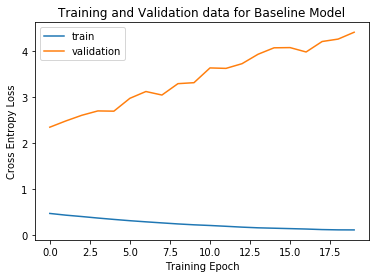

In [24]:
#print(history_baseline.history.keys())
# summarize history for accuracy
plot_model_history(history_baseline)

In [25]:
predictions_np = get_predictions_tensor(model_baseline, test_tensors)

In [26]:
print("Average categorical cross entropy: ", manual_total_cce(predictions_np, test_targets))

Average categorical cross entropy:  2.355062220374957


### Advanced Model

### Image Augmentation




In [27]:
from keras.preprocessing.image import ImageDataGenerator

def augment_data(train_tensors_input, valid_tensors_input, shift_width=0.1, shift_height=0.1, flip_hor=True,
                flip_vert=False):
    
    
    datagen_train = ImageDataGenerator(
        width_shift_range = shift_width,
        height_shift_range = shift_height,
        horizontal_flip = flip_hor,
        vertical_flip = flip_vert )

    # create and configure augmented image generator
    datagen_valid = ImageDataGenerator(
        width_shift_range = shift_width,
        height_shift_range = shift_height,
        horizontal_flip = flip_hor,
        vertical_flip = flip_vert )

    # fit augmented image generator on data
    datagen_train.fit(train_tensors_input)
    datagen_valid.fit(valid_tensors_input)
    
    return (datagen_train, datagen_valid)
    

In [28]:
(datagen_train, datagen_valid) = augment_data(train_tensors, valid_tensors)

In [29]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 16)        80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
__________

In [30]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:

epochs = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_augmentation.hdf5', 
                               verbose=1, save_best_only=True)

#With image augmentation

batch_size = 20

history_advanced = model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/50
1256/1256 [==============================] - 11s - loss: 1.7157 - acc: 0.3090 - val_loss: 1.6967 - val_acc: 0.3282
Epoch 2/50
1256/1256 [==============================] - 10s - loss: 1.5657 - acc: 0.3921 - val_loss: 1.5042 - val_acc: 0.4217
Epoch 3/50
1256/1256 [==============================] - 10s - loss: 1.4590 - acc: 0.4389 - val_loss: 1.4303 - val_acc: 0.4505
Epoch 4/50
1256/1256 [==============================] - 10s - loss: 1.4030 - acc: 0.4647 - val_loss: 1.4004 - val_acc: 0.4660
Epoch 5/50
1256/1256 [==============================] - 10s - loss: 1.3562 - acc: 0.4817 - val_loss: 1.3532 - val_acc: 0.4797
Epoch 6/50
1256/1256 [==============================] - 10s - loss: 1.3249 - acc: 0.4907 - val_loss: 1.3428 - val_acc: 0.4844
Epoch 7/50
1256/1256 [==============================] - 10s - loss: 1.2983 - acc: 0.5066 - val_loss: 1.3643 - val_acc: 0.4615
Epoch 8/50
1256/1256 [==============================] - 10s - loss: 1.2830 - acc: 0.5116 - val_loss: 1.2704 - val_acc:

1256/1256 [==============================] - 10s - loss: 1.2310 - acc: 0.5401 - val_loss: 1.2707 - val_acc: 0.5119
Epoch 31/50
1256/1256 [==============================] - 10s - loss: 1.2376 - acc: 0.5398 - val_loss: 1.2807 - val_acc: 0.5041
Epoch 32/50
1256/1256 [==============================] - 10s - loss: 1.2397 - acc: 0.5365 - val_loss: 1.2755 - val_acc: 0.5192
Epoch 33/50
1256/1256 [==============================] - 10s - loss: 1.2483 - acc: 0.5330 - val_loss: 1.3972 - val_acc: 0.5043
Epoch 34/50
1256/1256 [==============================] - 10s - loss: 1.2548 - acc: 0.5324 - val_loss: 1.2654 - val_acc: 0.5223
Epoch 35/50
1256/1256 [==============================] - 10s - loss: 1.2556 - acc: 0.5318 - val_loss: 1.3013 - val_acc: 0.5158
Epoch 36/50
1256/1256 [==============================] - 10s - loss: 1.2576 - acc: 0.5296 - val_loss: 1.3634 - val_acc: 0.5032
Epoch 37/50
1256/1256 [==============================] - 10s - loss: 1.2647 - acc: 0.5234 - val_loss: 1.2982 - val_acc: 0.4

In [32]:
model.load_weights('saved_models/weights.best.from_scratch_augmentation.hdf5')

In [33]:
# get index of predicted facial expression for test set images
print("Test accuracy: %.4f%% " % get_model_accuracy(model, test_tensors, test_targets))

Test accuracy: 56.0741% 


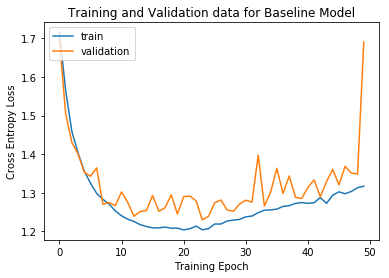

In [34]:
#print(history_advanced.history.keys())
# summarize history for accuracy
plot_model_history(history_advanced)

In [35]:
predictions_np = get_predictions_tensor(model, test_tensors)

In [36]:
print(manual_total_cce(predictions_np, test_targets))

1.18288026919212


### Transfer Learning

It is suitable to explore the use of other CNNs that have been used for other computer vision applications. Below, the performance of the pre-trained networks Inception, VGG-19 and Resnet50 will be explored

In [37]:

X_train_transf, X_test_transf, X_val_transf = X_train, X_test, X_val

y_train_transf, y_test_transf, y_val_transf = y_train, y_test, y_val


sample = df_to_tensor(X_train_transf, 48, reshape=False)


In [38]:
# creating transfer tensors

train_tensors_transf = df_to_tensor(X_train_transf,48,reshape=False, triple_channels=True).astype('float32')/255
valid_tensors_transf = df_to_tensor(X_val_transf,48, reshape=False, triple_channels=True).astype('float32')/255
test_tensors_transf = df_to_tensor(X_test_transf,48, reshape=False, triple_channels=True).astype('float32')/255

train_targets_transf = np.array(pd.get_dummies(y_train_transf))
valid_targets_transf = np.array(pd.get_dummies(y_val_transf))
test_targets_transf = np.array(pd.get_dummies(y_test_transf))


In [39]:
# Note: the code below is an adaptation of a code snippet by Prakash Jay,
# obtained from: https://towardsdatascience.com/transfer-learning-using-keras-d804b2e04ef8

img_width, img_height = 48, 48
batch_size = 16
epochs = 50

model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [40]:
# Image augmentation for transfer model

from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train_transf = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid_transf = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train_transf.fit(train_tensors_transf)
datagen_valid_transf.fit(valid_tensors_transf)

In [41]:
# change this code to freeze some of the layers of the VGG-19 model with the pre-trained weights

#for layer in model.layers:
#    layer.trainable = False



In [42]:
# duplicate of prakash jay code
x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax")(x)

# creating the final model 
model_final = Model(input = model.input, output = predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


In [43]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.transfer_example_six.hdf5', 
                               verbose=1, save_best_only=True)

history_transfer = model_final.fit_generator(datagen_train_transf.flow(train_tensors_transf, train_targets_transf, batch_size=batch_size),
                    steps_per_epoch=train_tensors_transf.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_valid_transf.flow(valid_tensors_transf, valid_targets_transf, batch_size=batch_size),
                    validation_steps=valid_tensors_transf.shape[0] // batch_size)

Epoch 1/50
1570/1570 [==============================] - 180s - loss: 1.8474 - acc: 0.2222 - val_loss: 1.7769 - val_acc: 0.2419
Epoch 2/50
1570/1570 [==============================] - 214s - loss: 1.7253 - acc: 0.2766 - val_loss: 1.7014 - val_acc: 0.3465
Epoch 3/50
1570/1570 [==============================] - 221s - loss: 1.6459 - acc: 0.3287 - val_loss: 1.6469 - val_acc: 0.3885
Epoch 4/50
1570/1570 [==============================] - 222s - loss: 1.5899 - acc: 0.3671 - val_loss: 1.5813 - val_acc: 0.4055
Epoch 5/50
1570/1570 [==============================] - 222s - loss: 1.5441 - acc: 0.4032 - val_loss: 1.5063 - val_acc: 0.4251
Epoch 6/50
1570/1570 [==============================] - 221s - loss: 1.5078 - acc: 0.4213 - val_loss: 1.4664 - val_acc: 0.4430
Epoch 7/50
1570/1570 [==============================] - 225s - loss: 1.4713 - acc: 0.4297 - val_loss: 1.4549 - val_acc: 0.4481
Epoch 8/50
1570/1570 [==============================] - 224s - loss: 1.4428 - acc: 0.4402 - val_loss: 1.4120 - 

1570/1570 [==============================] - 222s - loss: 1.0685 - acc: 0.6051 - val_loss: 1.1685 - val_acc: 0.5676
Epoch 27/50
1570/1570 [==============================] - 218s - loss: 1.0545 - acc: 0.6147 - val_loss: 1.1408 - val_acc: 0.5905
Epoch 28/50
1570/1570 [==============================] - 208s - loss: 1.0328 - acc: 0.6233 - val_loss: 1.1508 - val_acc: 0.5849
Epoch 29/50
1570/1570 [==============================] - 213s - loss: 1.0209 - acc: 0.6278 - val_loss: 1.1192 - val_acc: 0.5947
Epoch 30/50
1570/1570 [==============================] - 211s - loss: 1.0057 - acc: 0.6365 - val_loss: 1.1351 - val_acc: 0.5824
Epoch 31/50
1570/1570 [==============================] - 212s - loss: 0.9915 - acc: 0.6384 - val_loss: 1.1064 - val_acc: 0.5936
Epoch 32/50
1570/1570 [==============================] - 207s - loss: 0.9696 - acc: 0.6504 - val_loss: 1.1209 - val_acc: 0.5978
Epoch 33/50
1570/1570 [==============================] - 210s - loss: 0.9651 - acc: 0.6511 - val_loss: 1.1406 - val_

In [44]:
model_final.load_weights('saved_models/weights.best.transfer_example_six.hdf5')

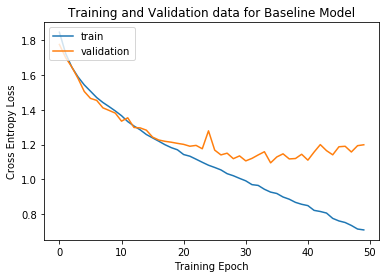

In [45]:
#print(history_transfer.history.keys())
plot_model_history(history_transfer)

In [46]:
# get index of predicted facial expression for test set images
expression_predictions_transf = [np.argmax(model_final.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors_transf]

# report test accuracy
test_accuracy = 100*np.sum(np.array(expression_predictions_transf)==np.argmax(test_targets_transf, axis=1))/len(expression_predictions_transf)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 62.9005%


In [47]:
predictions_np = get_predictions_tensor(model_final, test_tensors_transf)

print("Average categorical cross entropy is: ", manual_total_cce(predictions_np, test_targets_transf))

Average categorical cross entropy is:  1.0503048542716762


## Robustness Analysis

Below, the robustness of the final VGG-19 transfer learning model will be investigated. To do so, random Gaussian noise will be added to a number of images, and the performance of the classifier before and after the noise is added will be tested. 

In [48]:
def onehot_to_label(one_hot_array, labels_array):
    for i in range(len(one_hot_array)):
        if one_hot_array[i] == 1:
            break
    return labels_array[i]

(25120, 48, 48, 3)


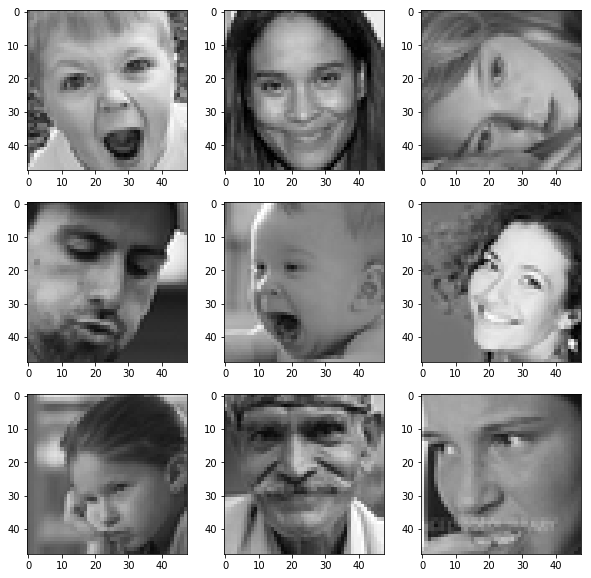

In [49]:
# Visualization of adding noise

# 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

samples = train_tensors_transf

seed_number = 0

print(samples.shape)

fig = plt.figure(figsize=(10, 10))

num_rows = 3

num_columns = 3

labels_words = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


labels = train_targets_transf

for i in range(num_rows*num_columns):
    ax = fig.add_subplot(num_rows,num_columns,i + 1)
    ax.imshow(samples[seed_number + i])

In [50]:
def add_noise(samples, number_of_images, std_dev=0.025, seed_number=0):
    for i in range(number_of_images):
        for pixel_x in samples[seed_number+i]:
            for pixel_y in range(len(pixel_x)):
                noise_ = np.random.normal(0,std_dev,1)[0]
                for rgb_value in range(len(pixel_x[pixel_y])):
                    pixel_x[pixel_y][rgb_value] += noise_
                    
                    if pixel_x[pixel_y][rgb_value] < 0:
                        pixel_x[pixel_y][rgb_value] = 0
                    if pixel_x[pixel_y][rgb_value] > 1:
                        pixel_x[pixel_y][rgb_value] = 1
    
    return samples

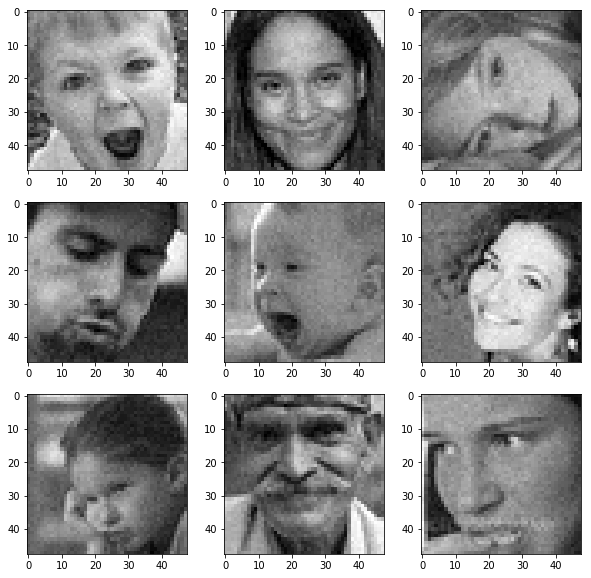

In [56]:
# visualize the effect of adding a small amount of gaussian noise to the samples

samples_noise = np.copy(train_tensors_transf)

fig = plt.figure(figsize=(10, 10))

# Change this value to get varying noise
noise_std_dev = 0.025

samples_noise = add_noise(samples_noise, num_rows*num_columns, std_dev = noise_std_dev)             
    
for i in range(num_rows*num_columns):
    ax = fig.add_subplot(num_rows,num_columns,i + 1)
    ax.imshow(samples_noise[seed_number + i])

In [57]:
# add the gaussian noise to each of the test_tensors_transf

test_tensors_transf_noise = np.copy(test_tensors_transf)
num_images = test_tensors_transf_noise.shape[0]
test_tensors_transf_noise = add_noise(test_tensors_transf_noise, num_images, std_dev = noise_std_dev)


In [58]:
predictions_np = get_predictions_tensor(model_final, test_tensors_transf_noise)

print("Categorical Cross Entropy Loss with noise added: ", manual_total_cce(predictions_np, test_targets_transf))

Categorical Cross Entropy Loss with noise added:  1.108950010054795


In [59]:
print("Accuracy with noise added: ", get_model_accuracy(model_final, test_tensors_transf_noise, test_targets_transf))

Accuracy with noise added:  60.6297018668
